# Set path to your data

In [1]:
name='Data'
path=name+'.csv'

# Import Libraries:

In [2]:
# Models and data processing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor, BaggingRegressor, VotingRegressor
# from sklearn.isotonic import IsotonicRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
import pickle

# Scores
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, max_error

# Math
from decimal import Decimal

import numpy as np
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Data
import pandas as pd
import os
import csv
# Sensitivity
from SALib.sample import saltelli
from SALib.analyze import sobol

# Data Augmentation
import numpy as np
from scipy.interpolate import interp1d

# Figures configurations

In [3]:
xw=5
yw=5
dpi=400
csfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["legend.loc"] = "lower right"

# Load and Process the Data:

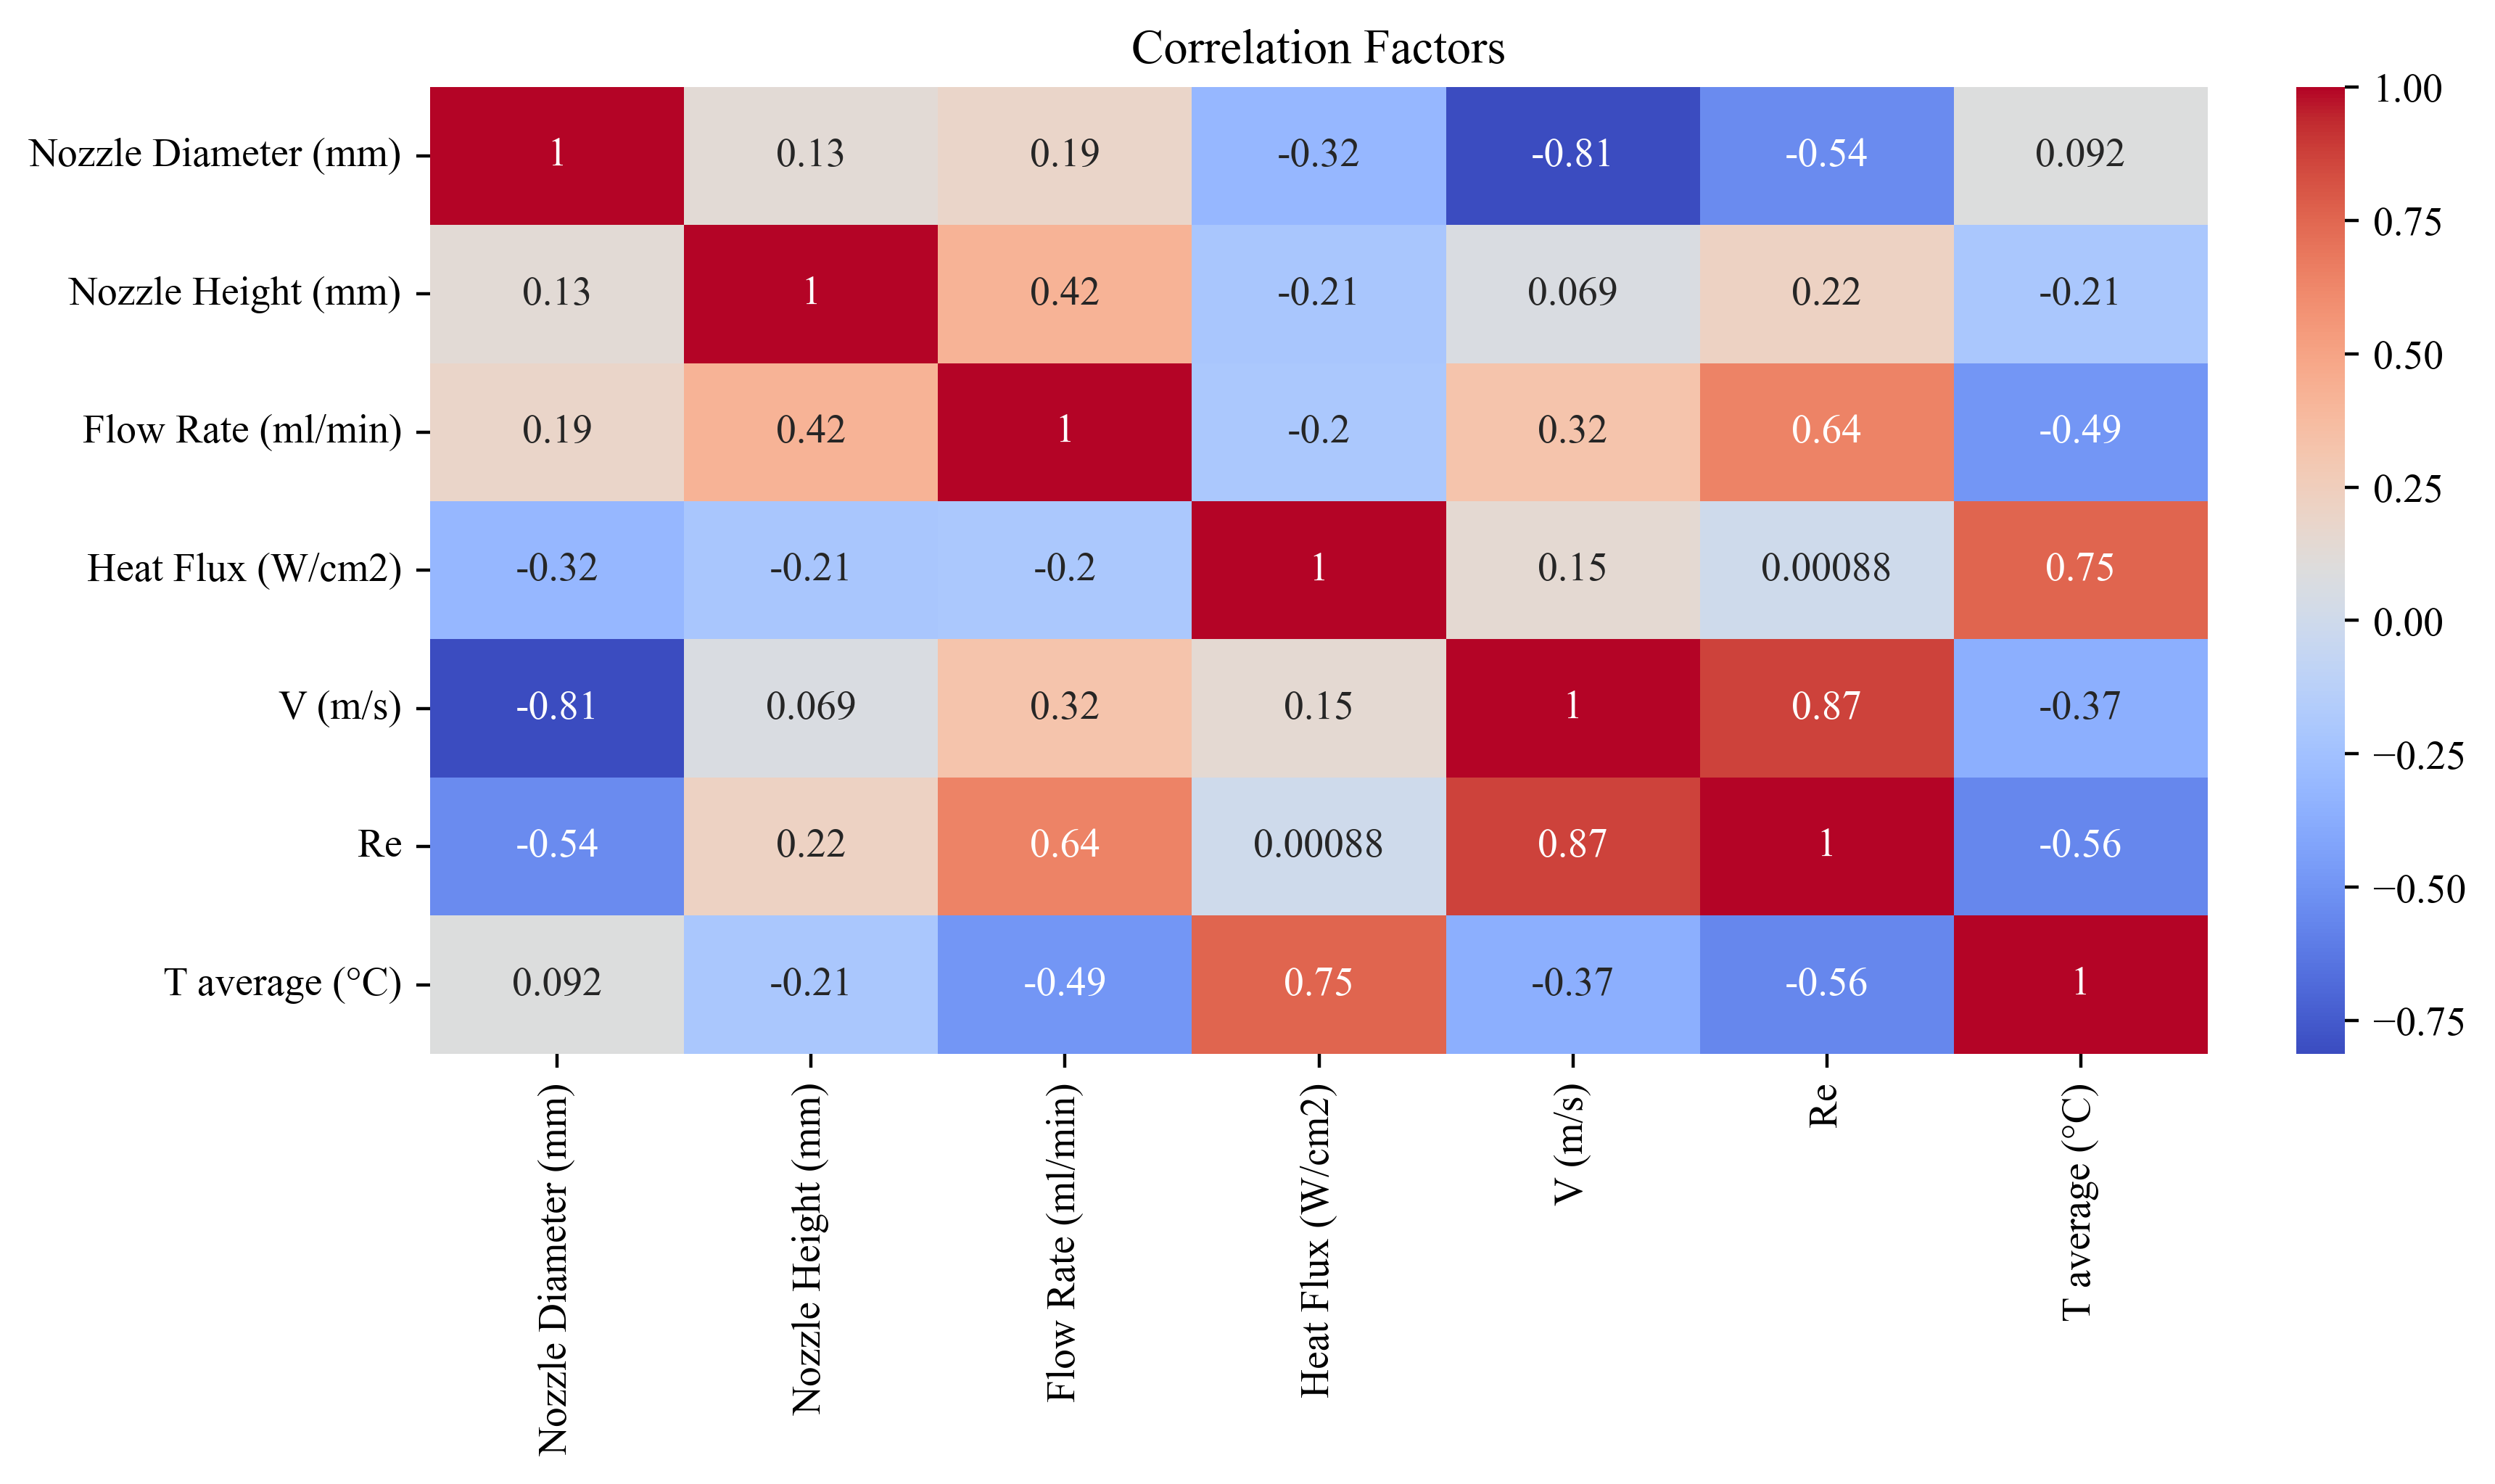

In [5]:
header_list = [ 'Nozzle Diameter (mm)', 	 'Nozzle Height (mm)', 	 'Flow Rate (ml/min)', 	 'Heat Flux (W/cm2)', 	 'V (m/s)', 	 'Re', 	 'T average (°C)']
data = pd.read_csv(path, names=header_list).replace('?', np.NaN).dropna()
X = data.get(['Nozzle Diameter (mm)', 	 'Nozzle Height (mm)', 	 'Flow Rate (ml/min)', 	 'Heat Flux (W/cm2)', 	 'V (m/s)', 	 'Re'])[1:]
y = data.get(['T average (°C)'])[1:]
X = np.asarray(X, dtype='float')
y = np.asarray(y, dtype='float')

df = pd.DataFrame(np.hstack((X,y)), columns=header_list)
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(facecolor = 'white',figsize=(1.7*xw,yw),dpi=dpi,layout='constrained')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Factors')
plt.savefig(name+' Correlation Factors'+'.png')
plt.show()

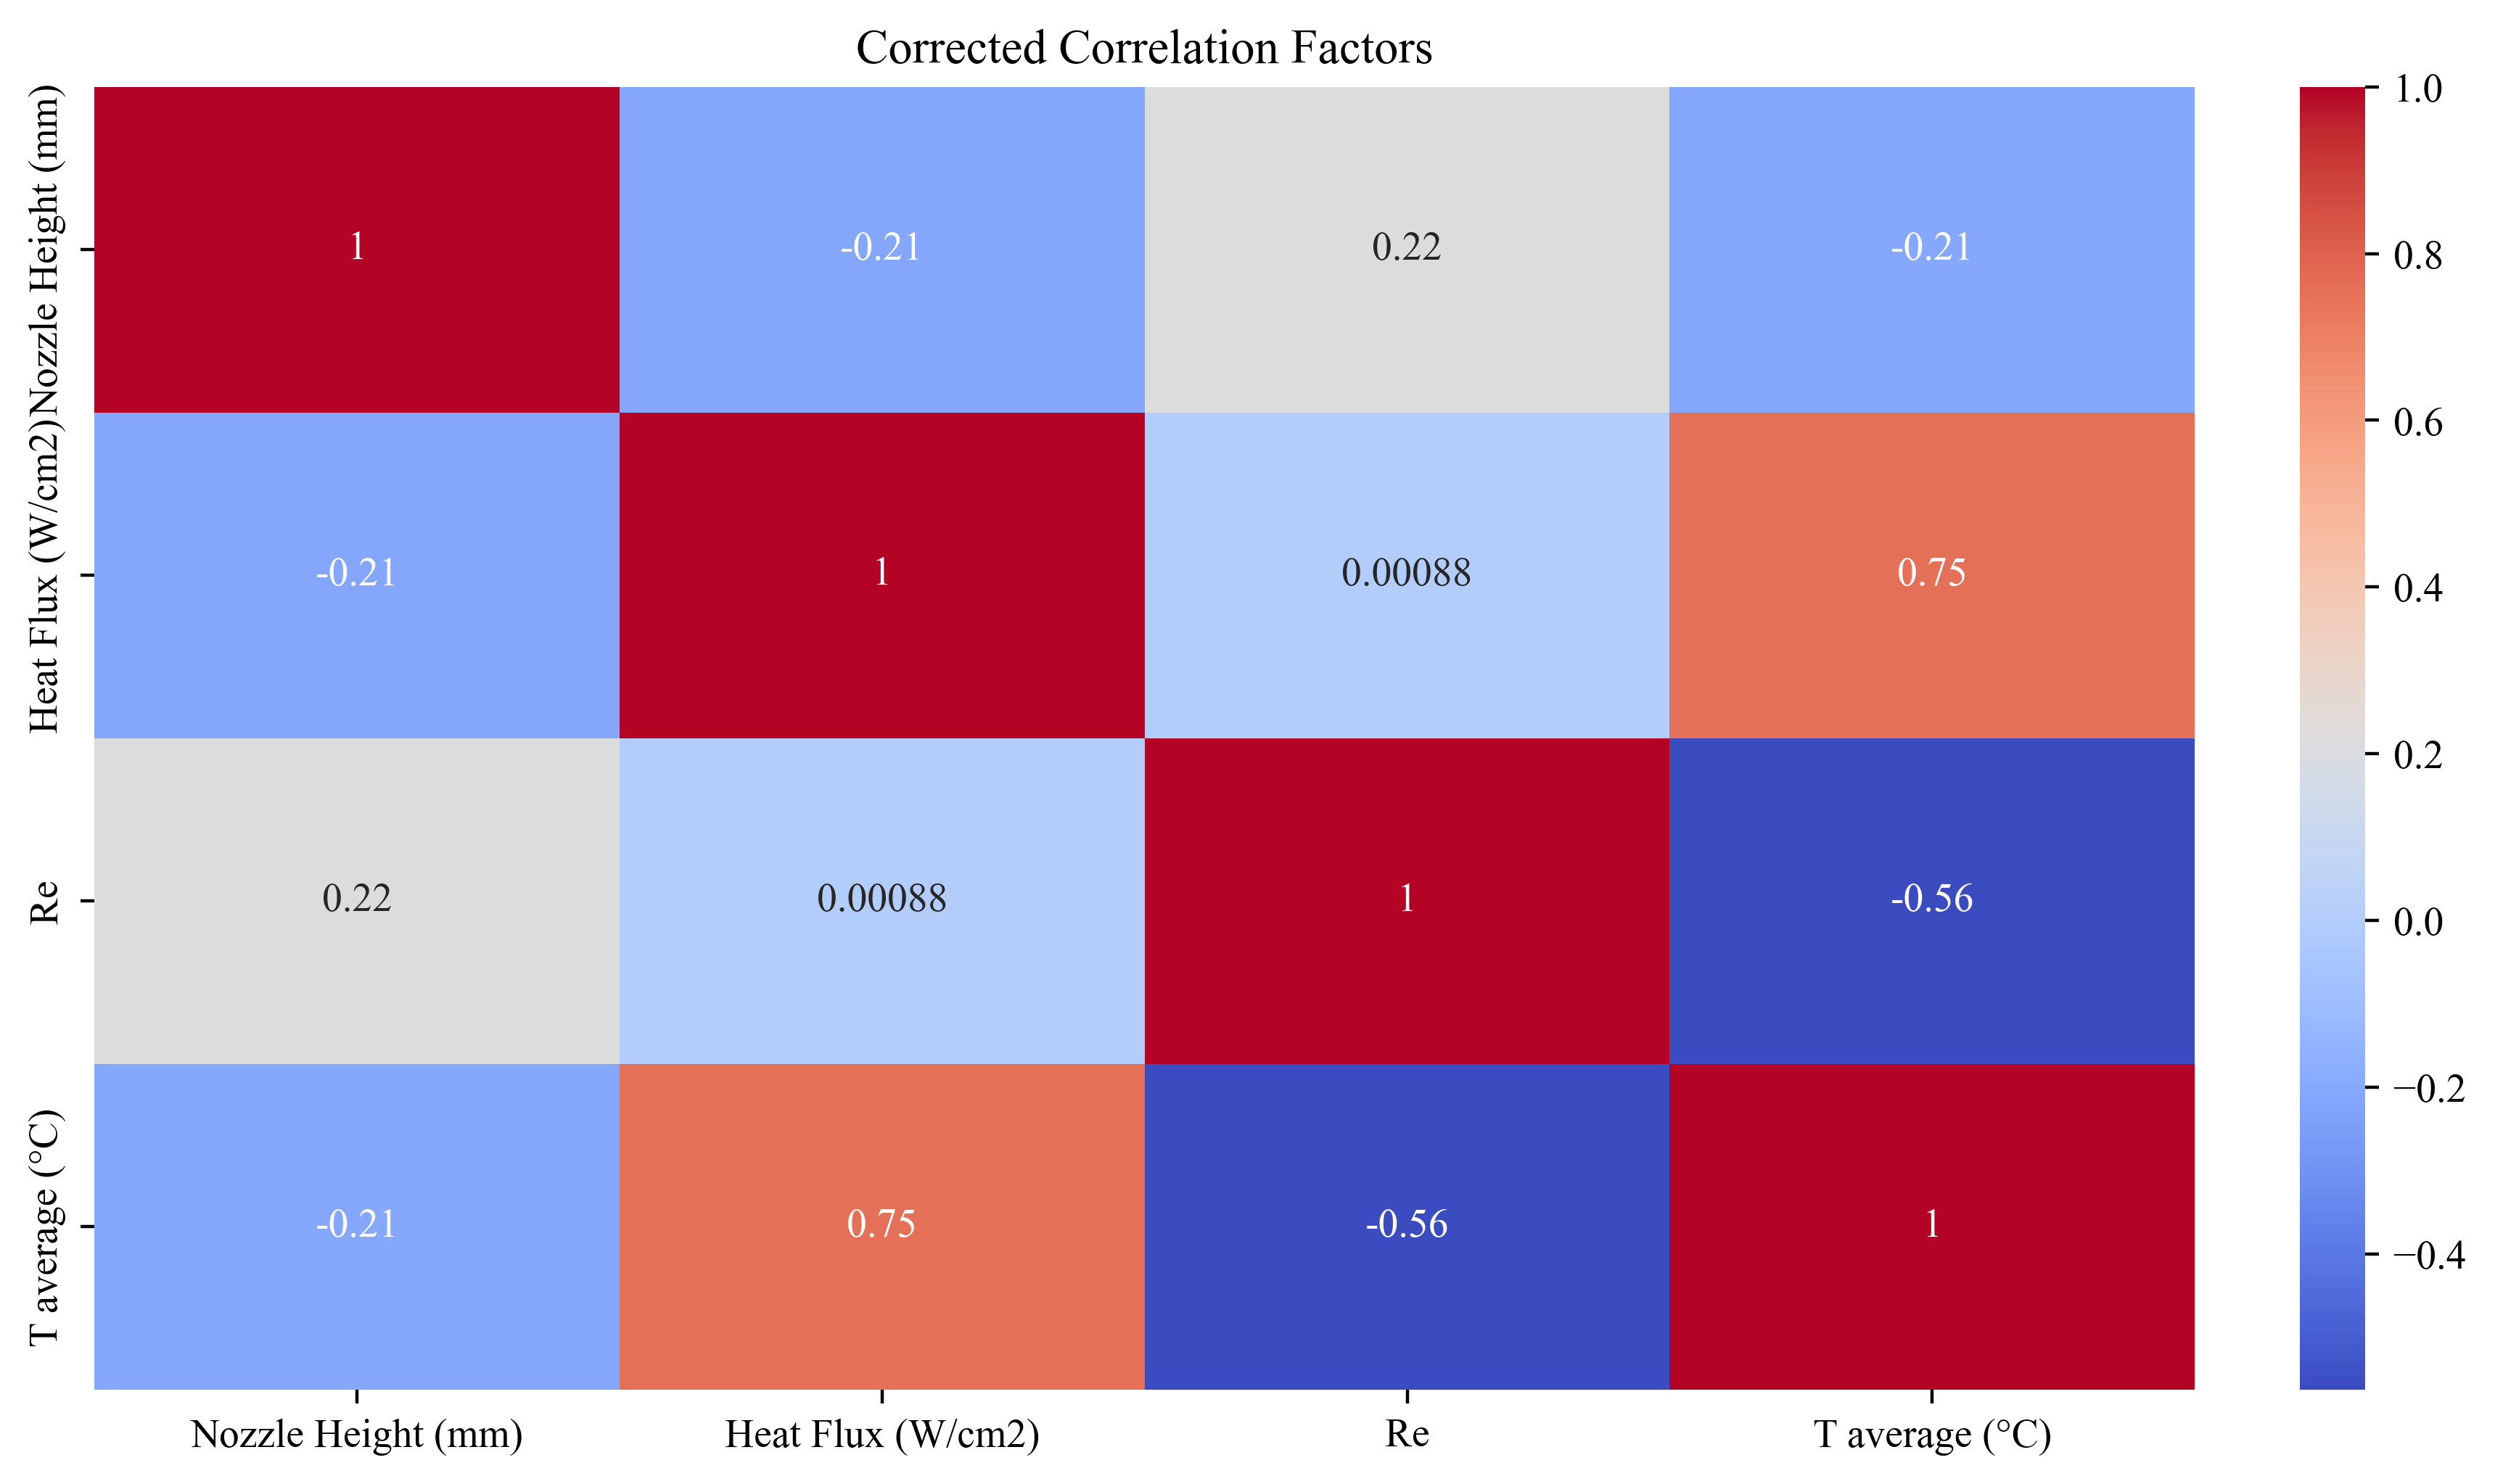

In [ ]:
header_list = [ 'Nozzle Diameter (mm)', 	 'Nozzle Height (mm)', 	 'Flow Rate (ml/min)', 	 'Heat Flux (W/cm2)', 	 'V(m/s)', 	 'Re', 	 'T average (°C)']
data = pd.read_csv(path, names=header_list).replace('?', np.NaN).dropna()
X_all = data.get(['Nozzle Height (mm)', 	 'Heat Flux (W/cm2)', 	 'Re'])[1:]
y_all = data.get(['T average (°C)'])[1:]
X_all = np.asarray(X_all, dtype='float')
y_all = np.asarray(y_all, dtype='float')

X = data.get(['Nozzle Height (mm)', 	 'Heat Flux (W/cm2)', 	 'Re'])[1:33]
y = data.get(['T average (°C)'])[1:33]
X = np.asarray(X, dtype='float')
y = np.asarray(y, dtype='float')

y_to_interpolate=y.copy()
X_to_interpolate=X.copy()


Xt = data.get(['Nozzle Height (mm)', 	 'Heat Flux (W/cm2)', 	 'Re'])[33:]
yt = data.get(['T average (°C)'])[33:]
Xt = np.asarray(Xt, dtype='float')
yt = np.asarray(yt, dtype='float')


header_list = ['Nozzle Height (mm)', 	 'Heat Flux (W/cm2)', 	 'Re', 'T average (°C)']
df = pd.DataFrame(np.hstack((X_all,y_all)), columns=header_list)
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(facecolor = 'white',figsize=(1.7*xw,yw),dpi=dpi,layout='constrained')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Corrected Correlation Factors')
plt.savefig(name+' Corrected Correlation Factors'+'.png')
plt.show()

In [ ]:
def interpolate_data(xy, target_size=500):

    Xg=xy

    current_size = len(Xg)
    
    # Generate new indices for interpolation
    new_indices = np.linspace(0, current_size - 1, target_size)
    
    # Interpolate each feature
    X_res = np.zeros((target_size, Xg.shape[1]))
    for i in range(Xg.shape[1]):
        interp_func = interp1d(np.arange(current_size), Xg[:, i], kind='linear')
        X_res[:, i] = interp_func(new_indices)
    
    
    return X_res

def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def regmix(X, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    index = np.random.permutation(len(X))
    X_mix = lam * X + (1 - lam) * X[index]
    return X_mix

def data_augmentation(x, mode, X_to_interpolate):
    if mode==1:
        Xx= interpolate_data(x, 500) 
    if mode==0:
        Xx= regmix(x, 0.5)
        Xx=np.vstack((x, Xx))

    est=RandomForestRegressor(max_depth=45, max_features='sqrt', n_estimators= 45)
    scaler = MinMaxScaler()
    X_to_interpolate = scaler.fit_transform(X_to_interpolate)
    Xx = scaler.transform(Xx)

    # To reverse the scaling
    Xx_original = scaler.inverse_transform(Xx)
    est.fit(X_to_interpolate, y_to_interpolate.ravel())
    yY=est.predict(Xx)

    Xxx=add_noise(Xx_original, 0.01)
    yyY=add_noise(yY, 0.1)
    xx=Xxx
    yy=yyY
    return xx, yy

Train-Test Split:

In [ ]:
# File paths
x_train_path = name+'_X_train.csv'
x_Val_path = name+'_X_Val.csv'
y_train_path = name+'_y_train.csv'
y_Val_path = name+'_y_Val.csv'


# Check if files exist
if all(os.path.exists(path) for path in [x_train_path, x_Val_path, y_train_path, y_Val_path]):
    X_train = pd.read_csv(x_train_path)
    X_Val = pd.read_csv(x_Val_path)
    y_train = pd.read_csv(y_train_path)
    y_Val = pd.read_csv(y_Val_path)
    X_train = np.asarray(X_train, dtype='float')
    y_train = np.asarray(y_train, dtype='float')
    X_Val = np.asarray(X_Val, dtype='float')
    y_Val = np.asarray(y_Val, dtype='float')
    print('Data is loaded.')
else:
    # Augment and Split the data
    if len(X)<500: 
        X, y=data_augmentation(X, 1, X_to_interpolate)
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.3, random_state=42)

    # # train data augmentation
    # X_train, y_train=data_augmentation(X_train, 1, X_to_interpolate)
    
    # Convert to DataFrames
    X_train_df = pd.DataFrame(X_train)
    X_Val_df = pd.DataFrame(X_Val)
    y_train_df = pd.DataFrame(y_train)
    y_Val_df = pd.DataFrame(y_Val)
    
    # Save to CSV
    X_train_df.to_csv(x_train_path, index=False)
    X_Val_df.to_csv(x_Val_path, index=False)
    y_train_df.to_csv(y_train_path, index=False)
    y_Val_df.to_csv(y_Val_path, index=False)
    print('Data is augmented, splitted, and saved.')

Data is loaded.


Feature Scaling:

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_Val = scaler.transform(X_Val)

# To reverse the scaling
X_train_original = scaler.inverse_transform(X_train)
X_Val_original = scaler.inverse_transform(X_Val)

Feature Selection with RFE:

In [9]:
estimator = RandomForestRegressor(max_depth=45, max_features='sqrt', n_estimators= 45)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_Val = selector.transform(X_Val)

selected_feature_indices = [i for i, rank in enumerate(selector.ranking_) if rank == 1]
print("Selected feature indices:", selected_feature_indices)

Selected feature indices: [0, 1, 2]


c:\Users\farix\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\farix\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Plot Feature Selection with RFE:

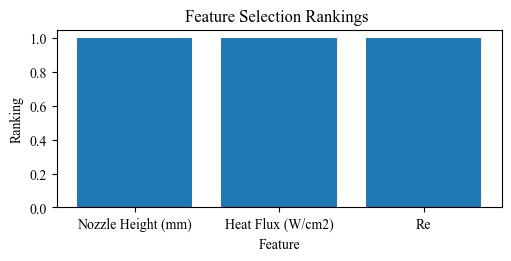

In [10]:
# Get feature rankings
feature_ranking = selector.ranking_

# Plot feature rankings
xw=2.5
yw=2.5
dpi=100
plt.figure(facecolor = 'white',figsize=(2*xw,yw),dpi=dpi,layout='constrained')
plt.bar(header_list[0:-1], feature_ranking)
plt.xlabel('Feature')
plt.ylabel('Ranking')
plt.title('Feature Selection Rankings ')
plt.savefig(name+' Feature Selection Rankings'+'.png')
plt.show()

# Train Sklearn Models

In [12]:
xw=3.5
yw=3.5
dpi=300
fx=7

def williams_plot(Number, predicted, orig_x, nameofflies2, name, xw=10, yw=6, dpi=100, fx=10):
    Residual = abs(Number - predicted)
    mean = Residual.mean()
    std = Residual.std()
    StdResidual = (Residual - mean) / std
    orig_x = orig_x.reshape(orig_x.shape[0], orig_x.shape[1])
    standardized_residuals = StdResidual.reshape(-1, 1)
    AA = orig_x.T.dot(orig_x)
    BB = np.linalg.inv(AA)
    CC = BB.dot(orig_x.T)
    DD = orig_x
    EE = (DD * CC.T)
    leverage = EE.sum(-1)
    lim1 = 3.0 * ((orig_x.shape[1] + 1) / (orig_x.shape[0]))
    print(lim1)

    lim2 = 3
    fig3 = plt.figure(facecolor='white', figsize=(xw, yw), dpi=dpi)
    ax3 = fig3.add_subplot(111)
    leverageo = []
    INDXo = []
    standardized_residualso = []
    leverages = []
    INDXs = []
    standardized_residualss = []
    leveragev = []
    INDXv = []
    standardized_residualsv = []
    for i in range(len(leverage)):
        if leverage[i] > lim1:
            leverageo = np.append(leverageo, leverage[i])
            standardized_residualso = np.append(standardized_residualso, standardized_residuals[i])
            INDXo = np.append(INDXo, i)
        elif standardized_residuals[i] > lim2 or standardized_residuals[i] < -lim2:
            leverages = np.append(leverages, leverage[i])
            standardized_residualss = np.append(standardized_residualss, standardized_residuals[i])
            INDXs = np.append(INDXs, i)
        else:
            leveragev = np.append(leveragev, leverage[i])
            standardized_residualsv = np.append(standardized_residualsv, standardized_residuals[i])
            INDXv = np.append(INDXv, i)

    INDXo = np.array(INDXo)
    INDXv = np.array(INDXv)
    INDXs = np.array(INDXs)

    print(INDXs)



    text1 = '''Out of leverage
    Ratio to the valid data= {0}'''.format('%.3f' % Decimal(INDXo.shape[0] / INDXv.shape[0]))
    text2 = '''Suspected
    Ratio to the valid data= {0}'''.format('%.3f' % Decimal(INDXs.shape[0] / INDXv.shape[0]))
    text3 = '''Valid
    Total number= {0}'''.format((INDXv.shape[0]))

    ax3.scatter(leverageo, standardized_residualso, marker='v', c='green', label=text1)
    ax3.scatter(leverages, standardized_residualss, marker='o', c='red', label=text2)
    ax3.scatter(leveragev, standardized_residualsv, marker='o', c='black', label=text3)
    ax3.axvline(x=lim1, ymin=0, ymax=1, c='blue', linestyle='--', label='HatL')
    ax3.axhline(y=lim2, xmin=0, xmax=1, c='#cf3721', alpha=0.5, label='STDRL')
    ax3.axhline(y=-lim2, xmin=0, xmax=1, c='#cf3721', alpha=0.5)

    ax3.set_xlabel('Hat leverage - {0}'.format(nameofflies2))
    ax3.set_ylabel('Standardized residuals - {0}'.format(nameofflies2))
    ax3.set_ylim([-20, 20])

    ax3.legend(facecolor='#f0f0f0', edgecolor='None', fontsize=fx)

    fig3.tight_layout()
    plt.savefig(name + nameofflies2 + '_William_splot' + '.png')

def sensitivity(X_all, model, header_list, selected_feature_indices, nameofflies2, name):
    # Define the model inputs
    bound_list=[]
    for ik in range(len(selected_feature_indices)):
        bound_list.append([np.min(X_all[:,ik]), np.max(X_all[:,ik])])
    problem = {
        'num_vars': len(selected_feature_indices),
        'names': [header_list[i] for i in selected_feature_indices],
        'bounds': bound_list
    }

    # Generate samples
    param_Values = saltelli.sample(problem, 128)

    # Run model (example)
    #Ysensive = Ishigami.eValuate(param_Values)

    Ysensive = np.zeros([param_Values.shape[0]])

    for i in range(Ysensive.shape[0]):
        Ysensive[i] = np.array(model.predict(param_Values[i,:].reshape(1, -1)))

    # Perform analysis
    Si = sobol.analyze(problem, Ysensive, print_to_console=True)

    # # Print the first-order sensitivity indices
    # print(Si['S1'])

    axes = Si.plot()
    # axes[0].set_yscale('log')
    fig = plt.gcf()  # get current figure
    plt.figure(facecolor = 'white',figsize=(1*xw,yw),dpi=dpi,layout='constrained')
    fig.set_size_inches(12, 2)
    fig.savefig(name+nameofflies2+'_Sobol'+'.png')
    return Si

testdata=scaler.transform(Xt.copy())
def Select_and_Train_model(modelname, model1):
    filename = name+'_'+modelname+'.sav'
    if not os.path.exists(filename):
        model1.fit(X_train, y_train.ravel())
        pickle.dump(model1, open(filename, 'wb'))
    else:
        model1 = pickle.load(open(filename, 'rb'))


    sensitivity(scaler.transform(X_all), model1, header_list, selected_feature_indices, modelname, name)

    y_pred = model1.predict(X_Val)
    y_pred2 = model1.predict(X_train)
    y_pred3 = model1.predict(testdata)

    mse = mean_squared_error(y_Val, y_pred)
    print(f'Val Mean Squared Error: {mse}')
    print(f'Val Root Mean Squared Error: {np.sqrt(mse)}')
    mae = mean_absolute_error(y_Val, y_pred)
    print(f'Val Mean Absolute Error: {mae}')
    print(f'Val Root Mean Absolute Error: {np.sqrt(mae)}')
    r2 = r2_score(y_Val, y_pred)
    print(f'Val R² Score: {r2}')
    maxe = max_error(y_Val, y_pred)
    print(f'Val Max Error: {maxe}')

    mse2 = mean_squared_error(y_train, y_pred2)
    print(f'Train Mean Squared Error: {mse2}')
    print(f'Train Root Mean Squared Error: {np.sqrt(mse2)}')
    mae2 = mean_absolute_error(y_train, y_pred2)
    print(f'Train Mean Absolute Error: {mae2}')
    print(f'Train Root Mean Absolute Error: {np.sqrt(mae2)}')
    r22 = r2_score(y_train, y_pred2)
    print(f'Train R² Score: {r22}')
    maxe2 = max_error(y_train, y_pred2)
    print(f'Train Max Error: {maxe2}')

    mse3 = mean_squared_error(yt, y_pred3)
    print(f'Test Mean Squared Error: {mse3}')
    print(f'Test Root Mean Squared Error: {np.sqrt(mse3)}')
    mae3 = mean_absolute_error(yt, y_pred3)
    print(f'Test Mean Absolute Error: {mae3}')
    print(f'Test Root Mean Absolute Error: {np.sqrt(mae3)}')
    r23 = r2_score(yt, y_pred3)
    print(f'Test R² Score: {r23}')
    maxe3 = max_error(yt, y_pred3)
    print(f'Test Max Error: {maxe3}')

    plt.figure(facecolor = 'white',figsize=(1*xw,yw),dpi=dpi,layout='constrained')
    plt.scatter(y_Val, y_pred, label='Val data', marker='o', c = '#283655')
    plt.scatter(y_train, y_pred2, label='Train data', marker='x', c = '#cf3721')
    plt.scatter(yt, y_pred3, label='Test data', marker='v', c = '#283655')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    text1='''Val: MAE = {0} | MSE = {1}
    R2 = {2}'''.format('%.2f' % Decimal(mae),'%.2f' % Decimal(mse),'%.4f' % Decimal(r2))
    text2='''Train: MAE = {0} | MSE = {1}
    R2 = {2}'''.format('%.2f' % Decimal(mae2),'%.2f' % Decimal(mse2),'%.4f' % Decimal(r22))
    text3='''Test: MAE = {0} | MSE = {1}
    R2 = {2}'''.format('%.2f' % Decimal(mae3),'%.2f' % Decimal(mse3),'%.4f' % Decimal(r23))

    plt.plot([], [], '|', label=text2, c='#f0f0f0')
    plt.plot([], [], '|', label=text1, c='#f0f0f0')
    plt.plot([], [], '|', label=text3, c='#f0f0f0')

    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.title(modelname+' Model Q-Q Plot: Actual vs Prediction')
    plt.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = fx)
    plt.savefig(name+modelname+' Model Q-Q Plot Actual vs Prediction'+'.png')
    plt.show()

    X_scaled=scaler.transform(X_all)
    Y_pred= model1.predict(X_scaled[:, selected_feature_indices])

    williams_plot(y_all, Y_pred, X_all, modelname, name)

    plt.figure(facecolor = 'white',figsize=(1*xw,yw),dpi=dpi,layout='constrained')
    indices = np.argsort(y_all[: , 0])
    plt.scatter(range(len(X_scaled)), Y_pred[indices], label='Prediction', marker='o', c = '#283655')
    plt.scatter(range(len(X_scaled)), y_all[indices], label='Actual', marker='x', c = '#cf3721')
    mse_sim = mean_squared_error(y_all, Y_pred)
    mae_sim = mean_absolute_error(y_all, Y_pred)
    r2_sim = r2_score(y_all, Y_pred)
    text1 = f'''MAE = {mae_sim:.2f} | MSE = {mse_sim:.2f}
    R2 = {r2_sim:.4f}'''
    plt.plot([], [], '|', label=text1, c='#f0f0f0')
    plt.ylabel('Average Temperature (C)')
    plt.xlabel('Data index')
    plt.title(modelname+' Model Prediction Plot: Actual vs Prediction')
    plt.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = fx)
    plt.savefig(name+modelname+' Model Prediction Plot Actual vs Prediction'+'.png')
    plt.show()

    return model1, r23, r2_sim

def k_fold_cross_Validation_with_tuning(model_name, model, param_grid, X, y, k=5):
    filename = name+'_'+model_name+'.sav'
    if not os.path.exists(filename):
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_
        print(f"{model_name} - Best Params: {grid_search.best_params_}, Best CV Score: {grid_search.best_score_:.4f}")
        return best_model
    else:
        print('Model is already tuned and trained')

def Load_and_Average_Models(model_names, X_train, y_train, X_Val, y_Val, scaler, selected_feature_indices, name, xw, yw, dpi, model_weights):
    predictions_train = []
    predictions_Val = []
    predictions_Test = []
    i=0

    for model_name in model_names:
        filename = name + '_' + model_name + '.sav'
        if os.path.exists(filename):
            ww=model_weights[i]
            model = pickle.load(open(filename, 'rb'))
            y_pred_train = ww*(model.predict(X_train).reshape(-1,1))
            y_pred_Val = ww*(model.predict(X_Val).reshape(-1,1))
            y_pred_test = ww*(model.predict(testdata).reshape(-1,1))
            predictions_train.append(y_pred_train)
            predictions_Val.append(y_pred_Val)
            predictions_Test.append(y_pred_test)
        else:
            print(f"Model file {filename} not found.")
        i +=1




    # Define the model inputs
    bound_list=[]
    for ik in range(len(selected_feature_indices)):
        bound_list.append([np.min((scaler.transform(X_all))[:,ik]), np.max((scaler.transform(X_all))[:,ik])])
    problem = {
        'num_vars': len(selected_feature_indices),
        'names': [header_list[i] for i in selected_feature_indices],
        'bounds': bound_list
    }

    # Generate samples
    param_Values = saltelli.sample(problem, 128)

    # Run model (example)
    #Ysensive = Ishigami.eValuate(param_Values)

    Ysensive = np.zeros([param_Values.shape[0]])
    Ysensive_list=np.zeros([param_Values.shape[0]])
    i=0
    for model_name in model_names:
        ww=model_weights[i]
        filename = name + '_' + model_name + '.sav'
        if os.path.exists(filename):
            model = pickle.load(open(filename, 'rb'))
            for i in range(Ysensive.shape[0]):
                Ysensive[i] = ww*(np.array(model.predict(param_Values[i,:].reshape(1, -1))))
            Ysensive_list=Ysensive_list+Ysensive
        else:
            print(f"Model file {filename} not found.")
        i =+1
    Ysensive_list=Ysensive_list/len(model_names)
    # Perform analysis
    Si = sobol.analyze(problem, Ysensive_list, print_to_console=True)

    # # Print the first-order sensitivity indices
    # print(Si['S1'])

    axes = Si.plot()
    # axes[0].set_yscale('log')
    fig = plt.gcf()  # get current figure
    plt.figure(facecolor = 'white',figsize=(1*xw,yw),dpi=dpi,layout='constrained')
    fig.set_size_inches(12, 2)
    fig.savefig(name+'Hybrid_Model'+'_Sobol'+'.png')


    # Averaging predictions
    y_pred_train_avg = np.mean(predictions_train, axis=0)
    y_pred_Val_avg = np.mean(predictions_Val, axis=0)
    y_pred_test_avg = np.mean(predictions_Test, axis=0)

    # Calculate metrics
    mse_test = mean_squared_error(yt, y_pred_test_avg)
    mae_test = mean_absolute_error(yt, y_pred_test_avg)
    r2_test = r2_score(yt, y_pred_test_avg)
    maxe_test = max_error(yt, y_pred_test_avg)


    mse_Val = mean_squared_error(y_Val, y_pred_Val_avg)
    mae_Val = mean_absolute_error(y_Val, y_pred_Val_avg)
    r2_Val = r2_score(y_Val, y_pred_Val_avg)
    maxe_Val = max_error(y_Val, y_pred_Val_avg)

    mse_train = mean_squared_error(y_train, y_pred_train_avg)
    mae_train = mean_absolute_error(y_train, y_pred_train_avg)
    r2_train = r2_score(y_train, y_pred_train_avg)
    maxe_train = max_error(y_train, y_pred_train_avg)

    print(f'Val Mean Squared Error: {mse_Val}')
    print(f'Val Root Mean Squared Error: {np.sqrt(mse_Val)}')
    print(f'Val Mean Absolute Error: {mae_Val}')
    print(f'Val Root Mean Absolute Error: {np.sqrt(mae_Val)}')
    print(f'Val R² Score: {r2_Val}')
    print(f'Val Max Error: {maxe_Val}')

    print(f'Train Mean Squared Error: {mse_train}')
    print(f'Train Root Mean Squared Error: {np.sqrt(mse_train)}')
    print(f'Train Mean Absolute Error: {mae_train}')
    print(f'Train Root Mean Absolute Error: {np.sqrt(mae_train)}')
    print(f'Train R² Score: {r2_train}')
    print(f'Train Max Error: {maxe_train}')

    print(f'Test Mean Squared Error: {mse_test}')
    print(f'Test Root Mean Squared Error: {np.sqrt(mse_test)}')
    print(f'Test Mean Absolute Error: {mae_test}')
    print(f'Test Root Mean Absolute Error: {np.sqrt(mae_test)}')
    print(f'Test R² Score: {r2_test}')
    print(f'Test Max Error: {maxe_test}')

    # Plotting
    plt.figure(facecolor='white', figsize=(1*xw, yw), dpi=dpi, layout='constrained')
    plt.scatter(y_Val, y_pred_Val_avg, label='Val data', marker='o', c='#283655')
    plt.scatter(yt, y_pred_test_avg, label='Test data', marker='v', c = '#283655')
    plt.scatter(y_train, y_pred_train_avg, label='Train data', marker='x', c='#cf3721')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    text1 = f'''Val: MAE = {mae_Val:.2f} | MSE = {mse_Val:.2f}
    R2 = {r2_Val:.4f}'''
    text2 = f'''Train: MAE = {mae_train:.2f} | MSE = {mse_train:.2f}
    R2 = {r2_train:.4f}'''
    text3 = f'''Test: MAE = {mae_test:.2f} | MSE = {mse_test:.2f}
    R2 = {r2_test:.4f}'''

    plt.plot([], [], '|', label=text2, c='#f0f0f0')
    plt.plot([], [], '|', label=text1, c='#f0f0f0')
    plt.plot([], [], '|', label=text3, c='#f0f0f0')
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.title('Hybrid Model Q-Q Plot: Actual vs Prediction')
    plt.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = fx)
    plt.savefig(name + 'Averaged_Model_Q-Q_Plot_Actual_vs_Prediction.png')
    plt.show()

    X_scaled=scaler.transform(X_all)
    predictions=[]
    i=0
    for model_name in model_names:
        ww=model_weights[i]
        filename = name + '_' + model_name + '.sav'
        if os.path.exists(filename):
            model = pickle.load(open(filename, 'rb'))
            Y_pred = ww*(model.predict(X_scaled).reshape(-1,1))
            predictions.append(Y_pred)
        else:
            print(f"Model file {filename} not found.")
        i =+1
    Y_pred_avg = np.mean(predictions, axis=0)

    williams_plot(y_all, Y_pred_avg, X_all, 'Hybrid', name)

    indices = np.argsort(y_all[: , 0])
    plt.figure(facecolor='white', figsize=(1*xw, yw), dpi=dpi, layout='constrained')
    plt.scatter(range(len(X_scaled)), Y_pred_avg[indices, :], label='Prediction', marker='o', c = '#283655')
    plt.scatter(range(len(X_scaled)), y_all[indices, :], label='Actual', marker='x', c = '#cf3721')
    mse_sim = mean_squared_error(y_all, Y_pred_avg)
    mae_sim = mean_absolute_error(y_all, Y_pred_avg)
    r2_sim = r2_score(y_all, Y_pred_avg)
    text1 = f'''MAE = {mae_sim:.2f} | MSE = {mse_sim:.2f}
    R2 = {r2_sim:.4f}'''
    plt.plot([], [], '|', label=text1, c='#f0f0f0')
    plt.ylabel('Average Temperature (C)')
    plt.xlabel('Data index')
    plt.title('Hybrid Model Prediction Plot: Actual vs Prediction')
    plt.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = fx)
    plt.savefig(name + 'Averaged_Model_Prediction_Plot_Actual_vs_Prediction.png')
    plt.show()

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    rmae = np.sqrt(mae)
    max_err = max_error(y_true, y_pred)
    return mse, mae, r2, rmse, rmae, max_err

def Load_Models(model_names, X_train, y_train, X_Val, y_Val, scaler, name, X_all, y_to_interpolate, X_test, y_test):
    metrics = []
    hyperparameters = []

    for model_name in model_names:
        filename = name + '_' + model_name + '.sav'
        if os.path.exists(filename):
            model = pickle.load(open(filename, 'rb'))
            # print(model)
            y_pred_train = model.predict(X_train).reshape(-1,1)
            y_pred_Val = model.predict(X_Val).reshape(-1,1)
            y_pred_test = model.predict(X_test).reshape(-1,1)
            y_pred_interpolate = model.predict(scaler.transform(X_all)).reshape(-1,1)

            # Calculate metrics
            metrics_train = calculate_metrics(y_train, y_pred_train)
            metrics_Val = calculate_metrics(y_Val, y_pred_Val)
            metrics_test = calculate_metrics(y_test, y_pred_test)
            metrics_interpolate = calculate_metrics(y_to_interpolate, y_pred_interpolate)

            # Append metrics to list
            metrics.append([model_name, 'Train'] + list(metrics_train))
            metrics.append([model_name, 'Validation'] + list(metrics_Val))
            metrics.append([model_name, 'Test'] + list(metrics_test))
            metrics.append([model_name, 'All'] + list(metrics_interpolate))

            # Save hyperparameters
            hyperparameters.append([model_name, model.get_params()])

        else:
            print(f"Model file {filename} not found.")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics, columns=['Model', 'Data', 'MSE', 'MAE', 'R2', 'RMSE', 'RMAE', 'Max Error'])
    metrics_df.to_csv(name + '_metrics.csv', index=False)

    # Save hyperparameters to CSV
    hyperparameters_df = pd.DataFrame(hyperparameters, columns=['Model', 'Hyperparameters'])
    hyperparameters_df.to_csv(name + '_hyperparameters.csv', index=False)

    # Plot metrics
    metrics_melted = metrics_df.melt(id_vars=['Model', 'Data'], var_name='Metric', value_name='Value')
    plt.figure(figsize=(14, 8))
    sns.barplot(data=metrics_melted, x='Model', y='Value', hue='Data', ci=None)
    plt.title('Model Performance Metrics')
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(name + '_metrics_plot.png')
    plt.show()

In [ ]:
models = [
    ('RF', RandomForestRegressor(), {'n_estimators': np.linspace(1, 200, 10, dtype=int).tolist(), 'max_depth': np.linspace(1, 200, 10, dtype=int).tolist(), 'max_features': ['auto', 'sqrt']}),
    ('SVR', SVR(), {'C': np.linspace(0.1, 1, 5).tolist(), 'epsilon': np.linspace(0.1, 1, 5).tolist(), 'gamma': ['auto', 'scale', 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}),
    ('MLP', MLPRegressor(), {'hidden_layer_sizes': [(10,), (50,), (100,)], 'activation': ['relu', 'tanh', 'identity', 'logistic'], 'solver': ['lbfgs', 'adam', 'sgd']}),
    ('DT', DecisionTreeRegressor(), {'max_depth': np.linspace(1, 200, 10, dtype=int).tolist(), 'max_features': ['auto', 'sqrt'], 'min_samples_split': np.linspace(1, 200, 10, dtype=int).tolist()}),
    ('MLR', LinearRegression(), {'fit_intercept': [True, False], 'copy_X': [True, False]}),
    ('KNR', KNeighborsRegressor(), {'n_neighbors': np.linspace(1, 50, 10, dtype=int).tolist(), 'weights': ['uniform', 'distance']}),
    ('GPR', GaussianProcessRegressor(), {'alpha': np.linspace(1e-10, 1e-9, 10).tolist()}),
    ('ADABoostR (RF)', AdaBoostRegressor(estimator=RandomForestRegressor(max_depth=45, max_features='sqrt', n_estimators= 45)), {'n_estimators': np.linspace(1, 200, 10, dtype=int).tolist()}), 
    ('BagR', BaggingRegressor(estimator=RandomForestRegressor(max_depth=45, max_features='sqrt', n_estimators= 45)), {'n_estimators': np.linspace(1, 200, 10, dtype=int).tolist()}),
    ('GBR', GradientBoostingRegressor(), {'n_estimators': np.linspace(1, 200, 10, dtype=int).tolist(), 'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']})
]

estimators=[]
test_scors_list=[]
for model_name, model, param_grid in models:
    best_model = k_fold_cross_Validation_with_tuning(model_name, model, param_grid, scaler.transform(X_to_interpolate), y_to_interpolate.ravel())
    best_model_param, sa, sb=Select_and_Train_model(model_name, best_model)
    estimators.append((model_name , best_model_param))
    test_scors_list.append((model_name , sa, sb))

reg = StackingRegressor(estimators=estimators[0:10],final_estimator=estimators[0][1])
best_model_param, sa, sb=Select_and_Train_model('StackR All (RF)', reg)
estimators.append(('StackR All (RF)' , best_model_param))
test_scors_list.append(('StackR All (RF)' , sa, sb))
reg2 = VotingRegressor(estimators=estimators[0:10])
best_model_param, sa, sb=Select_and_Train_model('VotR All', reg2)
estimators.append(('VotR All' , best_model_param))
test_scors_list.append(('VotR All' , sa, sb))

models = [('ADABoostR (MLP)', AdaBoostRegressor(estimator=MLPRegressor(hidden_layer_sizes=(5, 1), activation='relu', solver='lbfgs')), {'n_estimators': np.linspace(1, 200, 10, dtype=int).tolist()}), ('ADABoostR (MLR)', AdaBoostRegressor(estimator=LinearRegression()), {'n_estimators': np.linspace(1, 200, 10, dtype=int).tolist()})]

for model_name, model, param_grid in models:
    best_model = k_fold_cross_Validation_with_tuning(model_name, model, param_grid, scaler.transform(X_to_interpolate), y_to_interpolate.ravel())
    best_model_param, sa, sb=Select_and_Train_model(model_name, best_model)
    estimators.append((model_name , best_model_param))
    test_scors_list.append((model_name , sa, sb))

reg = StackingRegressor(estimators=estimators[0:10],final_estimator=MLPRegressor(hidden_layer_sizes=(5, 1), activation='relu', solver='lbfgs'))
best_model_param, sa, sb=Select_and_Train_model('StackR All (MLP)', reg)
estimators.append(('StackR All (MLP)' , best_model_param))
test_scors_list.append(('StackR All (MLP)' , sa, sb))

reg2 = VotingRegressor(estimators=[('ADABoostR (MLP)', pickle.load(open('Data_ADABoostR (MLP).sav', 'rb'))), ('StackR All (RF)', pickle.load(open('Data_StackR All (RF).sav', 'rb')))])
best_model_param, sa, sb=Select_and_Train_model('VotR of ADABoostR (MLP) and StackR All (RF)', reg2)
estimators.append(('VotR of ADABoostR (MLP) and StackR All (RF)' , best_model_param))
test_scors_list.append(('VotR of ADABoostR (MLP) and StackR All (RF)' , sa, sb))

reg2 = StackingRegressor(estimators=[('ADABoostR (MLP)', pickle.load(open('Data_ADABoostR (MLP).sav', 'rb'))), ('StackR All (RF)', pickle.load(open('Data_StackR All (RF).sav', 'rb')))], final_estimator=estimators[0][1])
best_model_param, sa, sb=Select_and_Train_model('StackR (RF) of ADABoostR (MLP) and StackR All (RF)', reg2)
estimators.append(('StackR (RF) of ADABoostR (MLP) and StackR All (RF)' , best_model_param))
test_scors_list.append(('StackR (RF) of ADABoostR (MLP) and StackR All (RF)' , sa, sb))

model_names = ['ADABoostR (MLP)', 'VotR of ADABoostR (MLP) and StackR All (RF)']
model_weights= [1, 1]
Load_and_Average_Models(model_names, X_train, y_train, X_Val, y_Val, scaler, selected_feature_indices, name, xw, yw, dpi, model_weights)

model_names = ['ADABoostR MLP', 'StackR']
model_weights= [1, 1]
Load_and_Average_Models(model_names, X_train, y_train, X_Val, y_Val, scaler, selected_feature_indices, name, xw, yw, dpi, model_weights)

model_names = ['RF', 'SVR', 'MLP', 'DT', 'MLR', 'KNR', 'GPR', 'ADABoostR (RF)', 'BagR', 'GBR', 'StackR All (RF)', 'VotR', 'ADABoostR (MLP)', 'StackR All (MLP)', 'ADABoostR (MLR)', 'VotR of ADABoostR (MLP) and StackR All (RF)', 'StackR (RF) of ADABoostR (MLP) and StackR All (RF)']
Load_Models(model_names, X_train, y_train, X_Val, y_Val, scaler, name, X_all, y_all, testdata, yt)

# Optimization

In [14]:
def hybrid_model(model_names, model_weights, X , Y, scaler, mode=0):
    i=0
    prediction=[]
    for model_name in model_names:
        filename = name + '_' + model_name + '.sav'
        if os.path.exists(filename):
            ww=model_weights[i]
            model = pickle.load(open(filename, 'rb'))
            y_pred = ww*(model.predict(scaler.transform(X)).reshape(-1,1))
            prediction.append(y_pred)
        else:
            print(f"Model file {filename} not found.")
        i +=1
    YP=np.mean(prediction, axis=0)
    if mode==1: print('R2=', r2_score(Y, YP))
    return YP

from scipy.optimize import dual_annealing,  basinhopping, differential_evolution, minimize, shgo, basinhopping, direct, brute, fmin
selected_feature_indices_copy=selected_feature_indices.copy()
if 1 in selected_feature_indices_copy: selected_feature_indices_copy.remove(0)
bounds = [(np.min(X_all[:, ik]), np.max(X_all[:, ik])) for ik in selected_feature_indices_copy]

# objective function
def objective(input):
    input = np.array(input).reshape(1, -1)
    X_in = np.zeros((input.shape[0], 3))
    X_in = np.array(X_in).reshape(1, -1)
    X_in[:,0]=X_all[:,0].mean() # Since the Nozzle h is not an effective input according to the Sobo sensitivity results it is considered constant
    X_in[:,1]=input[:, 0]
    X_in[:,2]=input[:, 1]
    model_names = ['ADABoostR (MLP)', 'VotR of ADABoostR (MLP) and StackR All (RF)']
    model_weights= [1, 1]
    pcd =hybrid_model(model_names, model_weights, X_in, y_all, scaler, 0)
    Tave=np.round(pcd,2)
    computed=abs(Tave-20)/X_in[:,1]  # 20 is the T0
    return computed

In [12]:
# Example usage of different optimization methods
result_dual_annealing = dual_annealing(objective, bounds, maxiter=5)

In [13]:
result_basinhopping = basinhopping(objective, x0=np.mean(bounds, axis=1), niter=5)

In [14]:
result_differential_evolution = differential_evolution(objective, bounds, maxiter=5)

In [21]:
result_minimize = minimize(objective, x0=np.mean(bounds, axis=1), method='Nelder-Mead', bounds=bounds)

In [22]:
result_shgo = shgo(objective, bounds)

In [23]:
result_direct = direct(objective, bounds, maxiter=5)

In [24]:
result_brute = brute(objective, ranges=bounds, full_output=True, Ns=1)

In [25]:
result_fmin = fmin(objective, x0=np.mean(bounds, axis=1), maxiter=5)

C:\Users\farix\AppData\Local\Temp\ipykernel_17052\554035005.py:1: RuntimeWarning: Maximum number of iterations has been exceeded.
  result_fmin = fmin(objective, x0=np.mean(bounds, axis=1), maxiter=5)


In [ ]:
model_names = ['ADABoostR (MLP)', 'VotR of ADABoostR (MLP) and StackR All (RF)']
model_weights= [1, 1]
xx_in=X_all.copy()
xx_in[:,0]=X_all[:,0].mean()
a=hybrid_model(model_names, model_weights, xx_in, y_all, scaler)
a_ind=np.where((a-20)/xx_in[:,1].reshape(-1,1)==min((a-20)/xx_in[:,1].reshape(-1,1)))[0]
a_inp=X_all[a_ind]

model_names = ['ADABoostR (MLP)', 'VotR of ADABoostR (MLP) and StackR All (RF)']
model_weights= [1, 1]
xx_in=X_all.copy()
a=hybrid_model(model_names, model_weights, xx_in, y_all, scaler)
a_ind=np.where(np.abs(a-y_all)==np.max(np.abs(a-y_all)))[0] # Find the one sus data in williams plot
xx_in[a_ind[0], :] # Find the one sus data in williams plot

Print

In [27]:
# Print the results
print("Dual Annealing Result:", result_dual_annealing)
print("Basin Hopping Result:", result_basinhopping)
print("Differential Evolution Result:", result_differential_evolution)
print("Minimize (Nelder-Mead) Result:", result_minimize)
print("SHGO Result:", result_shgo)
print("DIRECT Result:", result_direct)
print("Brute Force Result:", result_brute)
print("Fmin Result:", result_fmin)
print("Minimum Predicted Value:", min((a-20)/xx_in[:,1].reshape(-1,1)))

Dual Annealing Result:      fun: array([[0.23655906]])
 message: ['Maximum number of iteration reached']
    nfev: 228
    nhev: 0
     nit: 5
    njev: 69
  status: 0
 success: True
       x: array([  64.50820236, 5531.97715655])
Basin Hopping Result:                         fun: 0.3213349718552049
 lowest_optimization_result:       fun: 0.3213349718552049
 hess_inv: array([[9.78529057e+03, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00]])
      jac: array([-0.00478481,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 267
      nit: 1
     njev: 87
   status: 2
  success: False
        x: array([  67.1573339 , 3778.96900197])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 6
                       nfev: 1265
                        nit: 5
                       njev: 411
                    success: False
                          x: array([  67.

Save

In [ ]:
if not os.path.exists('optimization_results.csv'):
    # Collect results
    results = {
        "Method": ["Dual Annealing", "Basin Hopping", "Differential Evolution", "Minimize (Nelder-Mead)", "SHGO", "DIRECT", "Brute Force", "Fmin", "Minimum Predicted Value"],
        "1/h ( °C.cm2/W )": [(result_dual_annealing.fun), result_basinhopping.fun, result_differential_evolution.fun, result_minimize.fun, result_shgo.fun, result_direct.fun, result_brute[1], (result_fmin)[0], (min((a-20)/xx_in[:,1].reshape(-1,1)))[0]],
        "Input": [result_dual_annealing.x, result_basinhopping.x, result_differential_evolution.x, result_minimize.x, result_shgo.x, result_direct.x, result_brute[0], result_fmin, (a_inp)[0]],
        'Nozzle Height (mm)': [(a_inp)[0,0], (a_inp)[0,0], (a_inp)[0,0], (a_inp)[0,0], (a_inp)[0,0], (a_inp)[0,0], (a_inp)[0,0], (a_inp)[0,0], (a_inp)[0,0]],
        'Heat Flux (W/cm2)': [(result_dual_annealing.x)[0], (result_basinhopping.x)[0], (result_differential_evolution.x)[0], (result_minimize.x)[0], (result_shgo.x)[0], (result_direct.x)[0], (result_brute[0])[0], (result_fmin)[0], (a_inp)[0,1]],
        'Re': [(result_dual_annealing.x)[1], (result_basinhopping.x)[1], (result_differential_evolution.x)[1], (result_minimize.x)[1], (result_shgo.x)[1], (result_direct.x)[1], (result_brute[0])[1], (result_fmin)[1], (a_inp)[0,2]]
    }


    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Save to CSV
    df_results.to_csv("optimization_results.csv", index=False)

    # Print the results
    print("Optimization results saved to optimization_results.csv")


    # Find the closest X_all indices and compare y_all with optimization results
    closest_X = []
    closest_y_values = []

    for input_val in results["Input"]:
        distances = np.linalg.norm(X_all[:, selected_feature_indices_copy] - input_val[:2], axis=1)
        closest_index = np.argmin(distances)
        closest_X.append(X_all[closest_index, selected_feature_indices_copy])
        closest_y_values.append(y_all[closest_index])

    # Combine the data into a single list of lists
    combined_data = [list(closest_X[i]) + list(closest_y_values[i]) for i in range(len(closest_X))]

    # Define the header
    header = ['Heat Flux (W/cm2)', 'Re', 'T average (°C)']

    # Write to CSV
    with open('closest_Values.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(combined_data)

    print("Closest values saved to closest_Values.csv")

Optimization results saved to optimization_results5.csv
Closest values saved to closest_Values5.csv


# Fluid Type

In [ ]:
import pandas as pd
import numpy as np
import itertools

# Define the fluid properties
fluids = {
    'water': 0.001182365,
    'Al2O3': 0.001115682,
    'TiO2': 0.001109806,
    'CuO': 0.001064742,
    'PCM1': 0.001144396,
    'PCM3': 0.001340225
}

# Generate V values
V_values = np.linspace(1.4, 10.6, 42)

# List of diameters
diameters = [0.6, 0.8, 1.0]

# Threshold for comparison
threshold = 5961.6
X = 100  # Define your threshold difference here

# Compute all combinations of V, diameter, and nu
results = []
for V, diameter, (fluid_name, nu) in itertools.product(V_values, diameters, fluids.items()):
    result = (V * diameter) / nu
    if abs(result - threshold) < X:
        results.append([V, diameter, nu, fluid_name, result])

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['V (m/s)', 'Nozzle Diameter (mm)', 'Dynamic Viscosity (Pa-s)', 'Fluid Name', 'Re'])

# Save the filtered results to a new CSV file
if not os.path.exists('fluid_type_results.csv'):
    results_df.to_csv('fluid_type_results.csv', index=False)
    print("Filtered results saved to 'fluid_type_results.csv'")
else:
    print('Already done!')

Filtered results saved to 'fluid_type_results.csv'
